In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches
import matplotlib.colors as colors
import Q2Q1FEM
import PolyFEM
import pandas as pd 
import itertools
from copy import deepcopy
import amplify
from amplify import BinaryPoly, gen_symbols,sum_poly, decode_solution
from amplify import Solver
from amplify.client import FixstarsClient
token = "your token "
import time

In [2]:
nelm = 16
Node,Element,NodeBC=Q2Q1FEM.SquareMeshQ2(nelm)
Node_P,Element_P,NodeBC_P=Q2Q1FEM.SquareMeshQ1(nelm)  #Don't use NodeBC_P!!!!!(NodeBC_P contains the value of the velocity🥶)
fem_NElem = Element.shape[0]
zIni = np.ones(fem_NElem)

In [3]:
adj_elem_list = []
for i in range(nelm*nelm):
    t_adj = []
    if i%nelm!=0:
        t_u = i-1
        t_adj.append(t_u)
    if i>=nelm:
        t_l = i-nelm
        t_adj.append(t_l)
    if i%nelm!=nelm-1:
        t_o = i+1
        t_adj.append(t_o)
    if (nelm*nelm)-i>nelm:
        t_r = i+nelm
        t_adj.append(t_r)
    adj_elem_list.append(t_adj)
for i in range(nelm*nelm*2):
    j = i+nelm**2
    t_adj = []
    if i%(2*nelm)!=0:
        t_u = j-1
        t_adj.append(t_u)
    if i<nelm:
        t_l = j-nelm
        t_adj.append(t_l)
    elif i>=2*nelm:
        t_l = j-2*nelm
        t_adj.append(t_l)
    if i%(2*nelm)!=2*nelm-1:
        t_o = j+1
        t_adj.append(t_o)
    if i<(nelm-1)*nelm*2:
        t_r = j+2*nelm
        t_adj.append(t_r)
    adj_elem_list.append(t_adj)

In [7]:
def Construct_QUBO(Nelm,u,v,volfrac,num_bit_per,xc):
    ## bit string
    v_limited = volfrac*Nelm

    ## coef for porous resistivity
    coef_pr = 10**5/4
    coef_pr_pres = [0 for _ in range(Nelm)]

    ## coef for energy loss, eqn constraint, gradient energy, heviside function, boundary constraint, domain constraints
    alpha_el = 5
    alpha_eqn_c = 1
    alpha_ge = 10.0
    alpha_hev = 300.0
    alpha_bc = 1.0
    alpha_dc = 600.0

    ## qubit
    q = gen_symbols(BinaryPoly,Nelm,num_bit_per+1)

    ## objective function
    obj_func = BinaryPoly()

    ### energy loss
    for t_id in range(Nelm):
        coef_pr_e = (1-q[t_id][-1])*coef_pr
        t_uvec = u[t_id]/xc*2
        t_vvec = v[t_id]/xc*2
        obj_func += alpha_el*(coef_pr_e*(t_uvec*t_uvec+t_vvec*t_vvec) )

    ### gradient energy
    for t_id,t_q in enumerate(q):
        for tt_id in adj_elem_list[t_id]:
            phi_i = (sum_poly(t_q[:-1])/num_bit_per*2)-1
            phi_j = (sum_poly(q[tt_id][:-1])/num_bit_per*2)-1
            obj_func += alpha_ge/2*(phi_i-phi_j)**2

    ### boundary constraint
    # for t_id, t_q in enumerate(q):
    #     if t_id in in_bound_element+out_bound_element:
    #         obj_func += alpha_bc*((sum_poly(t_q[:-1])/num_bit_per*2)-1 -1)**2
    #     else:
    #         pass

    ### heviside function
    for t_id, t_q in enumerate(q):
        obj_func += alpha_hev*(sum_poly(t_q[:-1])/num_bit_per - t_q[-1])**2

    ### domaint constraints
    obj_func += alpha_dc*(sum_poly([t[-1] for t in q]) - v_limited)**2
    
    client = FixstarsClient()
    client.parameters.timeout = 500   # タイムアウト X m秒
    client.token = token # ローカル環境で使用する場合は、Amplify AEのアクセストークンを入力してください
    client.parameters.outputs.duplicate = True  # 同じエネルギー値の解を列挙するオプション（解が複数個あるため）

    solver = Solver(client)
    # solver.sort_solution = False # 解をエネルギー順にソートしない
    # solver.client.parameters.outputs.sort = False # 解をエネルギー順にソートしない
    # solver.client.parameters.outputs.num_outputs = 0 # エネルギーの更新ごとに得られたすべての解をsolutionsに含める
    # d = {"sampling_time":[],"energy":[]} #履歴データを格納する
    result = solver.solve(obj_func)
    # for t, s in zip(solver.client_result.timing.time_stamps, result.solutions):
    #     if s.is_feasible:
    #         d["sampling_time"].append(t)
    #         d["energy"].append(s.energy)
    # number=solver.client_result.execution_parameters.num_iterations
    # print("Solved",flush=True)
    
    solution = decode_solution(q, result[0].values)
    
    return solution

--- 1th iteration ---
f:12.541138481953908
Volume fraction: 0.7630208333333335


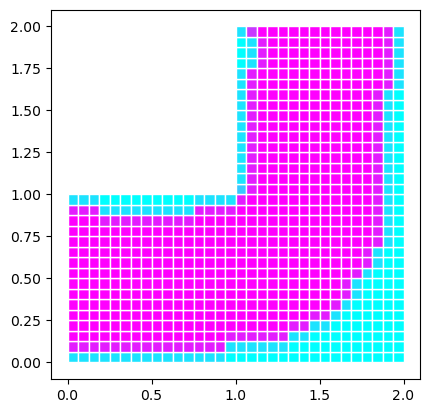

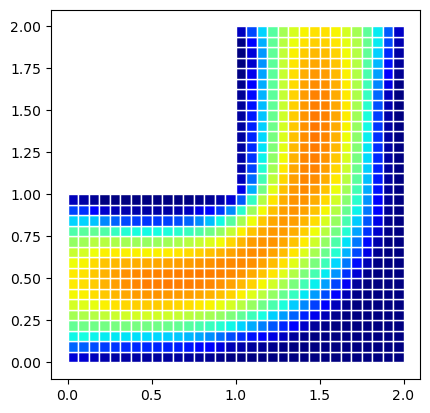

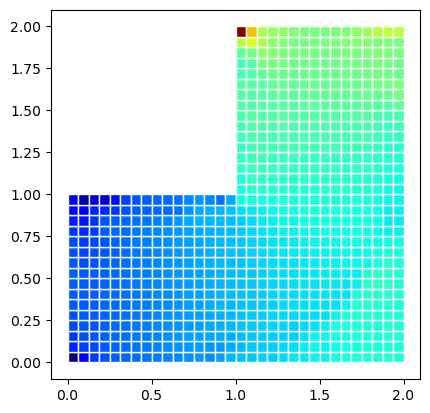

pressure: 2.2741665297946794 -1.2468658646054809
--- 2th iteration ---
f:12.063825969799801
Volume fraction: 0.7554976851851852


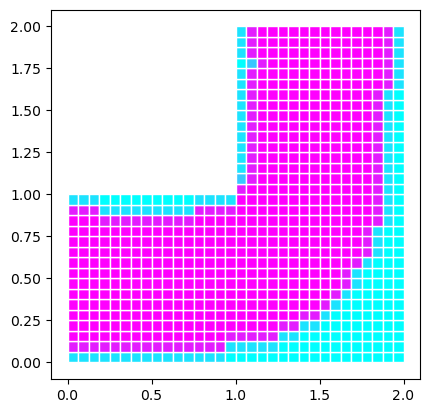

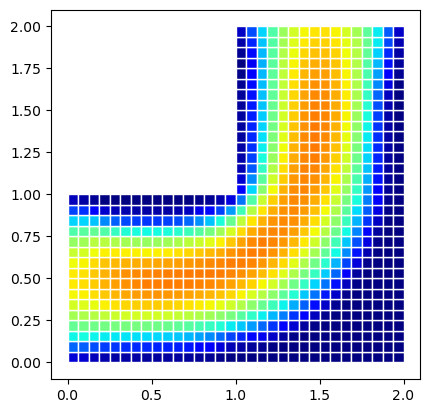

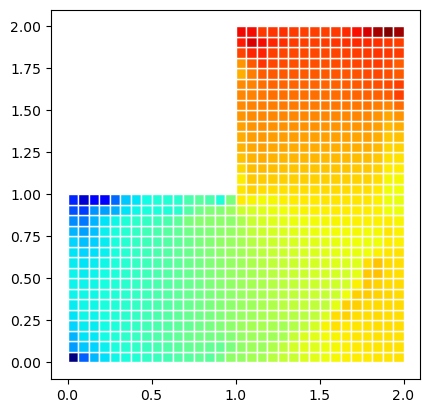

pressure: 0.8293174222156978 -1.2464465669163238
--- 3th iteration ---
f:11.644574552030845
Volume fraction: 0.7540509259259262


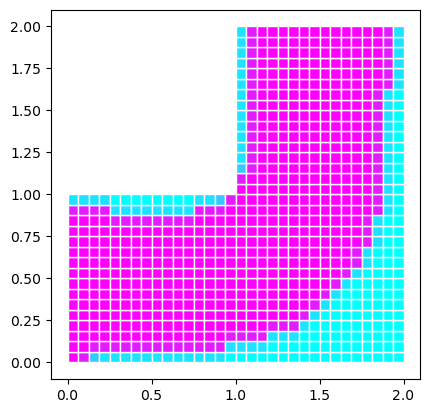

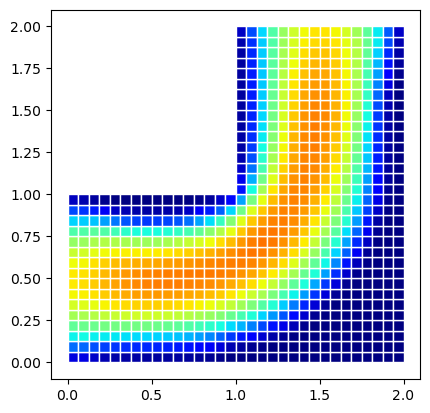

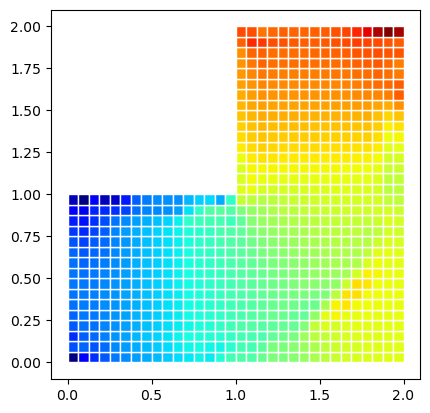

pressure: 0.82038828784408 -0.9162715458464404
--- 4th iteration ---
f:11.561659617606873
Volume fraction: 0.7540509259259264


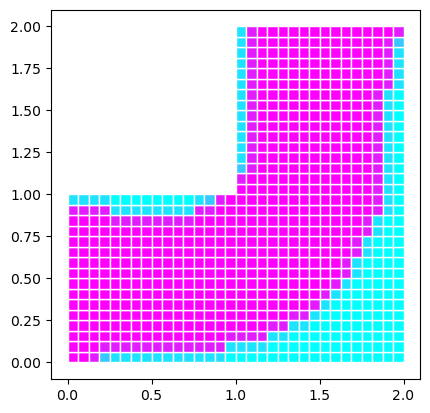

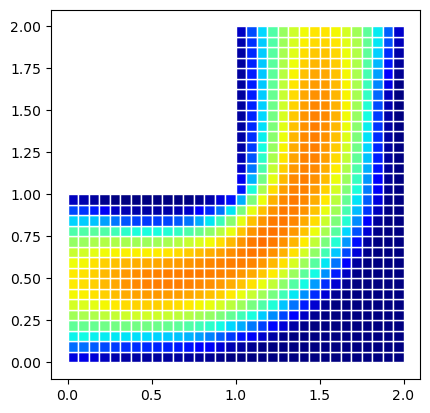

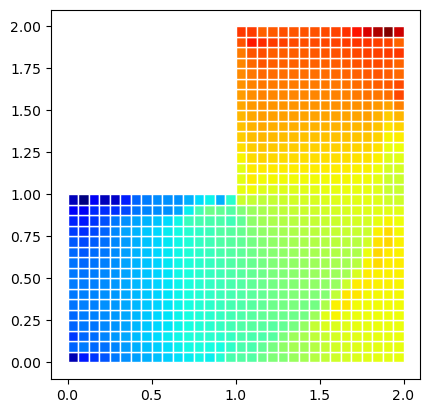

pressure: 0.7859155925208285 -0.9165156083603713
--- 5th iteration ---
f:11.532811928533658
Volume fraction: 0.752748842592593


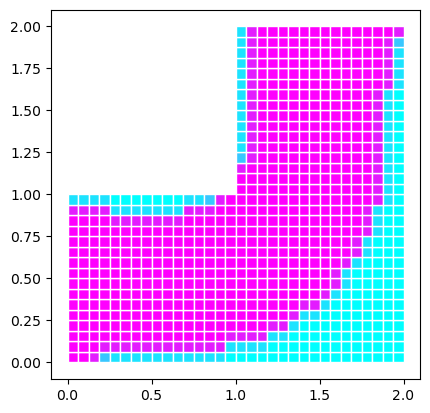

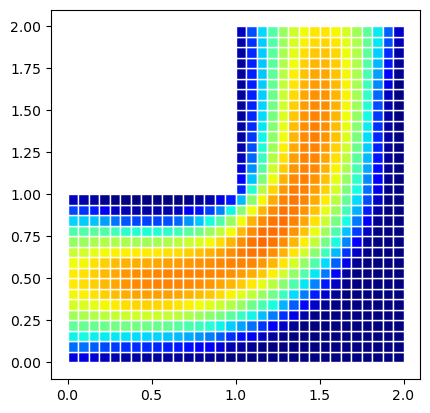

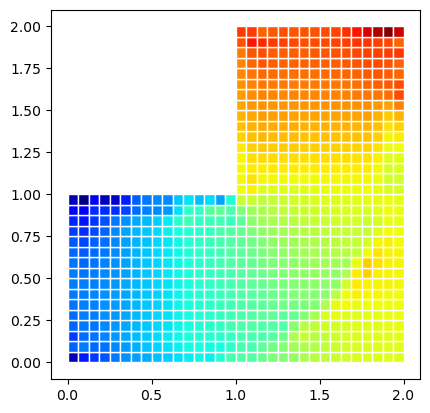

pressure: 0.7858163242172481 -0.9143221289970367
--- 6th iteration ---
f:11.532811928533658
Volume fraction: 0.752748842592593


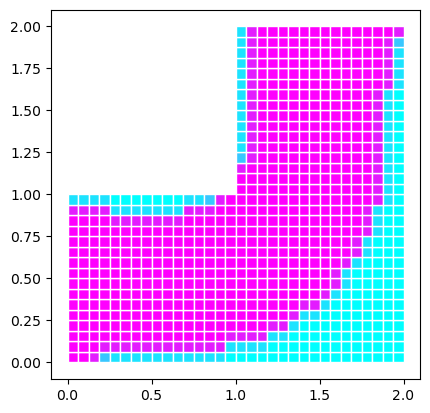

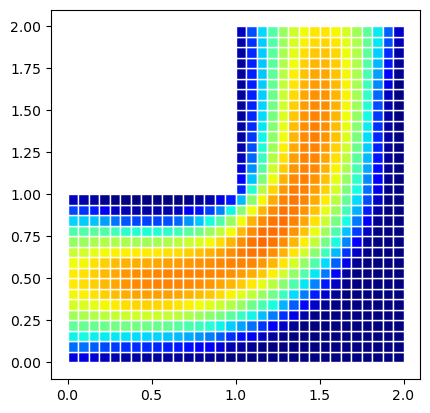

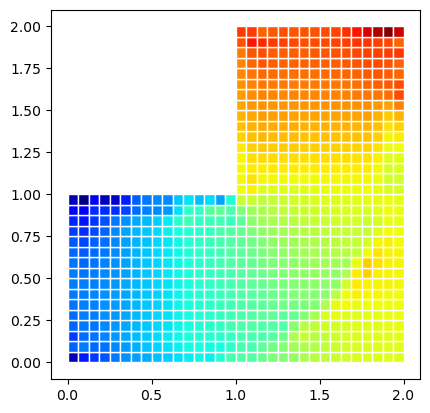

pressure: 0.7858163242172481 -0.9143221289970367
67.38306951522827


In [8]:
maxiter=15
num_bit_per = 9

start = time.time()
p,f,u,v = Q2Q1FEM.Q2Q1FEM(Node,Element,NodeBC,Node_P,Element_P,NodeBC_P,zIni)
#p,f,u,v = PolyFEM.PolyFEM(nelm,zIni)
z_QA_new = zIni
obj = []
frac = []
for i in range(maxiter):
    print('--- {}th iteration ---'.format(i+1))
    z_QA = z_QA_new
    if i==0:
        xc = 2
    else:
        xc = max(np.sqrt(u**2+v**2))
    solution = Construct_QUBO(fem_NElem,u,v,volfrac=0.75,num_bit_per=num_bit_per,xc=xc)
    sol = []
    # heviside=[]
    # check=[]
    for t in solution:
        pred_t_d = np.sum(t[:-1])/num_bit_per
        sol.append(pred_t_d)
        # pred_t_h = t[-1]
        # heviside.append(pred_t_h)
        # if pred_t_d >= 0.5:
        #     check.append(1)
        # else:
        #     check.append(0)
    #print('check',(np.array(check)-np.array(heviside)).sum())    
    z_QA_new = np.array(sol)
    p,f_new,u,v = Q2Q1FEM.Q2Q1FEM(Node,Element,NodeBC,Node_P,Element_P,NodeBC_P,z_QA_new)
    #p,f_new,u,v = PolyFEM.PolyFEM(nelm,z_QA_new)
    #print(max(u**2+v**2),min(u**2+v**2),np.mean(u**2+v**2))
    #p_poly,f_new_poly,u_poly,v_poly = PolyFEM.PolyFEM(Node_P,Element_P,NodeBC_P,z_QA_new)
    print('f:{}'.format(f_new*1000))
    print('Volume fraction: {}'.format(sum(sol)/768))
    obj.append(f_new*1000)
    frac.append(sum(sol)/768)
    Q2Q1FEM.Plot_patch(nelm,Node_P,Element_P,z_QA_new,1,0,cmap='cool')
    #Q2Q1FEM.Plot_quiver(Node_P,Element_P,u,v)
    Q2Q1FEM.Plot_patch(nelm,Node_P,Element_P,(np.sqrt(u**2+v**2)),1.5,0,cmap='jet')
    Q2Q1FEM.Plot_patch(nelm,Node_P,Element_P,p,max(p),min(p),cmap='jet')
    print('pressure:',max(p),min(p))
    #print(np.max(np.abs(z_QA-z_QA_new)))
    if np.max(np.abs(z_QA-z_QA_new))<0.01:
        break
end = time.time()
print(end-start)

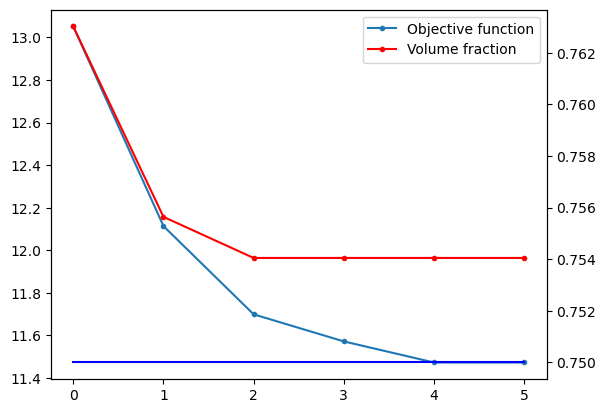

In [6]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(obj,label="Objective function",marker='.')
ax2.plot(frac,label='Volume fraction',marker='.',color='r')
ax2.plot([0,i],[0.75,0.75],color='b')
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2)

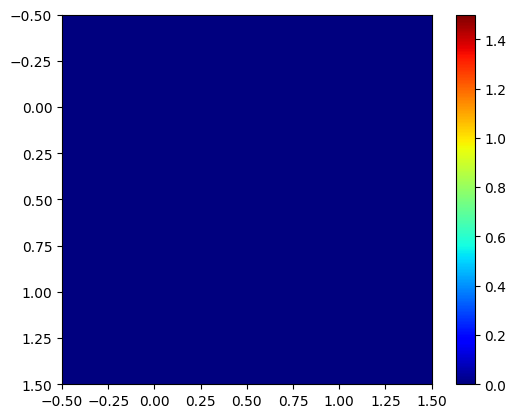

In [13]:
plt.imshow(np.zeros(4).reshape(2,2),vmin=0,vmax=1.5,cmap='jet')
plt.colorbar()